In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import re

In [2]:
# data paths
wikidata_path = '../data/wikidata-movies.json.gz'
rotten_path = '../data/rotten-tomatoes.json.gz'
omdb_path = '../data/omdb-data.json.gz'

In [3]:
# retrieve data
wikidata_data = pd.read_json(wikidata_path, orient='record', lines=True)
rotten_data = pd.read_json(rotten_path, orient='record', lines=True)
omdb_data = pd.read_json(omdb_path, orient='record', lines=True)

In [4]:
# merge data
data = pd.merge(wikidata_data, rotten_data, on='imdb_id', how='left')
data = pd.merge(data, omdb_data, on='imdb_id', how='left')

In [5]:
# Popular actors: Morgan Freeman, Leonardo DiCaprio, Brad Pitt, Michael Caine, Robert Di Niro, Natalie Portman, Anne Hathaway, Talia Shire, Diane Keaton, Keira Knightley. 
def is_popular_actor(actor_list):
    popular_actors = ['Q48337', 'Q37876', 'Q38111', 'Q35332', 'Q123351', 'Q36949', 'Q36301', 'Q108622', 'Q102642', 'Q42581']
    result = any(elem in actor_list for elem in popular_actors)
    return result

# Popular directors: Ertem Egilmez, Akira Kurosawa, Alfred Hitchcock, Ingmar Bergman, Steven Spielberg, Billy Wilder, Christopher Nolan, Stanley Kubrick, Martin Scorcese, William Wyler, Yasujuro Ozu, Charles Chaplin, Quentin Tarantino, Hayao Mayazaki, Frances Ford Coppola, Mani Ratnam, Peter Jackson, Sergio Leone, Luis Bunuel, David Fincher.
def is_popular_director(director_list):
    popular_directors = ['Q3057501', 'Q8006', 'Q7374', 'Q7546', 'Q8877', 'Q51547', 'Q25191', 'Q2001', 'Q41148', 'Q51495', 'Q55402', 'Q882', 'Q3772', 'Q55400', 'Q56094', 'Q174648', 'Q4465', 'Q164562', 'Q51545', 'Q184903']
    result = any(elem in director_list for elem in popular_directors)
    return result

In [6]:
# Calculates how many Oscars won
def won_oscar(awards):
    match = re.search('Won \d Oscar', awards)
    wins = 0
    if match:
        oscar_wins = match.group(0)
        wins = re.findall('\d+', oscar_wins)
        wins = wins[0]
    wins = float(wins)
    return wins

# Calculates how many Oscars nominated
def nominated_for_oscar(awards):
    match = re.search('Nominated for \d Oscar', awards)
    nominations = 0
    if match:
        oscar_nominations = match.group(0)
        nominations = re.findall('\d+', oscar_nominations)
        nominations = nominations[0]
    nominations = float(nominations)
    return nominations

In [7]:
# QUESTION: Does popularity of actors/actresses in movie relate to movie's success?
# Get required data for question, drop any fields that are missing: 
pop_data = data[['imdb_id', 'cast_member', 'omdb_awards', 'audience_average', 'critic_average', 'made_profit']]
# Remove any values that don't exist from these columns, except awards (could be none!)
pop_data = pop_data.dropna(subset=['imdb_id', 'cast_member', 'audience_average', 'critic_average', 'made_profit'])
# Set index
pop_data = pop_data.set_index('imdb_id')

In [8]:
pop_data['has_popular_actor'] = pop_data['cast_member'].apply(lambda x: is_popular_actor(x))

In [9]:
# Add columns for Oscar wins and Oscar nominations
pop_data['oscar_wins'] = pop_data['omdb_awards'].apply(lambda x: won_oscar(x))
pop_data['oscar_nominations'] = pop_data['omdb_awards'].apply(lambda x: nominated_for_oscar(x))

In [10]:
has_pop_actor = pop_data.loc[pop_data['has_popular_actor'] == True]
no_pop_actor = pop_data.loc[pop_data['has_popular_actor'] == False]

In [11]:
# Audience Ratings
has_pop_actor_audience = has_pop_actor['audience_average']
no_pop_actor_audience = no_pop_actor['audience_average']
# Take a look at the means...
print("Has top actor, audience mean: ", has_pop_actor_audience.mean())
print("Has no top actor, audience mean: ", no_pop_actor_audience.mean())
# Testing with a ttest...
ttest_p_audience = stats.ttest_ind(has_pop_actor_audience, no_pop_actor_audience).pvalue
print("T-test on the audience data: ", ttest_p_audience)

Has top actor, audience mean:  3.6121621621621625
Has no top actor, audience mean:  3.4881383855024715
T-test on the audience data:  0.03600328042056285


In [12]:
# Critic Ratings
has_pop_actor_critic = has_pop_actor['critic_average']
no_pop_actor_critic = no_pop_actor['critic_average']
# Take a look at the means...
print("Has top actor, critic mean: ", has_pop_actor_critic.mean())
print("Has no top actor, critic mean: ", no_pop_actor_critic.mean())
# Testing with a ttest...
ttest_p_critic = stats.ttest_ind(has_pop_actor_critic, no_pop_actor_critic).pvalue
print("T-test on the critic data: ", ttest_p_critic)

Has top actor, critic mean:  6.678378378378378
Has no top actor, critic mean:  6.3189456342668855
T-test on the critic data:  0.05511131427533335


In [13]:
# Made Profit
# Look at the percentage of movies that made a profit
has_pop_actor_made_profit = has_pop_actor[has_pop_actor.made_profit == True].shape[0]
has_pop_actor_total = has_pop_actor.shape[0]
no_pop_actor_made_profit = no_pop_actor[no_pop_actor.made_profit == True].shape[0]
no_pop_actor_total = no_pop_actor.shape[0]

print("Percent of movies featuring most popular actors that made a profit:", has_pop_actor_made_profit/has_pop_actor_total)
print("Percent of movies not featuring any of the popular actors that made a profit:", no_pop_actor_made_profit/no_pop_actor_total)

Percent of movies featuring most popular actors that made a profit: 0.8513513513513513
Percent of movies not featuring any of the popular actors that made a profit: 0.8434925864909391


In [14]:
# Won Oscars 
has_pop_actor_won_oscar = has_pop_actor['oscar_wins']
no_pop_actor_won_oscar = no_pop_actor['oscar_wins']

#Take a look at the means...
print("Has top actor, 'oscars won' mean: ", has_pop_actor_won_oscar.mean())
print("Has no top actor, 'oscars won'  mean: ", no_pop_actor_won_oscar.mean())
# Testing with a ttest...
ttest_p_won_oscar = stats.ttest_ind(has_pop_actor_won_oscar, no_pop_actor_won_oscar).pvalue
print("T-test on the 'oscars won' data: ", ttest_p_won_oscar)

Has top actor, 'oscars won' mean:  0.6351351351351351
Has no top actor, 'oscars won'  mean:  0.385502471169687
T-test on the 'oscars won' data:  0.09144818889942259


In [15]:
# Nominated For Oscars 
has_pop_actor_oscar_nominated = has_pop_actor['oscar_nominations']
no_pop_actor_oscar_nominated = no_pop_actor['oscar_nominations']

#Take a look at the means...
print("Has top actor, 'oscars nominated' mean: ", has_pop_actor_oscar_nominated.mean())
print("Has no top actor, 'oscars nominated' mean: ", no_pop_actor_oscar_nominated.mean())
# Testing with a ttest...
ttest_p_oscar_nominated = stats.ttest_ind(has_pop_actor_oscar_nominated, no_pop_actor_oscar_nominated).pvalue
print("T-test on the 'oscars nominated' data: ", ttest_p_oscar_nominated)

Has top actor, 'oscars nominated' mean:  0.5405405405405406
Has no top actor, 'oscars nominated' mean:  0.43657331136738053
T-test on the 'oscars nominated' data:  0.4553574261161094


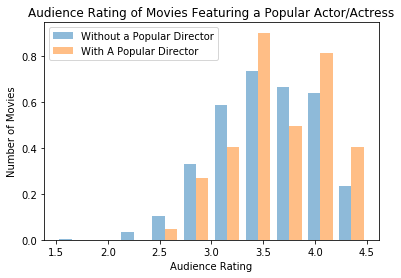

In [16]:
plt.hist([no_pop_actor['audience_average'], has_pop_actor['audience_average']], 10, alpha=0.5, density=True)
plt.xlabel('Audience Rating')
plt.ylabel('Number of Movies')
plt.title('Audience Rating of Movies Featuring a Popular Actor/Actress')
plt.legend(['Without a Popular Director','With A Popular Director'])

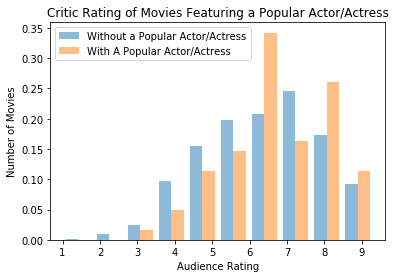

In [17]:
plt.hist([no_pop_actor['critic_average'], has_pop_actor['critic_average']], 10, alpha=0.5, density=True)
plt.xlabel('Audience Rating')
plt.ylabel('Number of Movies')
plt.title('Critic Rating of Movies Featuring a Popular Actor/Actress')
plt.legend(['Without a Popular Actor/Actress','With A Popular Actor/Actress'])

In [18]:
# QUESTION: Does popularity of directors of movie relate to movie's success?
# Get required data for question, drop any fields that are missing: 
pop_data_dir = data[['imdb_id', 'director', 'omdb_awards', 'audience_average', 'critic_average', 'made_profit']]
# Remove any values that don't exist from these columns, except awards (could be none!)
pop_data_dir = pop_data_dir.dropna(subset=['imdb_id', 'director', 'audience_average', 'critic_average', 'made_profit'])
# Set index
pop_data_dir = pop_data_dir.set_index('imdb_id')

In [19]:
pop_data_dir['has_popular_director'] = pop_data_dir['director'].apply(lambda x: is_popular_director(x))

In [20]:
# Add columns for Oscar wins and Oscar nominations
pop_data_dir['oscar_wins'] = pop_data_dir['omdb_awards'].apply(lambda x: won_oscar(x))
pop_data_dir['oscar_nominations'] = pop_data_dir['omdb_awards'].apply(lambda x: nominated_for_oscar(x))

In [21]:
has_pop_director = pop_data_dir.loc[pop_data_dir['has_popular_director'] == True]
no_pop_director = pop_data_dir.loc[pop_data_dir['has_popular_director'] == False]

In [22]:
# Audience Ratings
has_pop_director_audience = has_pop_director['audience_average']
no_pop_director_audience = no_pop_director['audience_average']
# Take a look at the means...
print("Has top director, audience mean: ", has_pop_director_audience.mean())
print("Has no top directoor, audience mean: ", no_pop_director_audience.mean())
# Testing with a ttest...
ttest_p_audience = stats.ttest_ind(has_pop_director_audience, no_pop_director_audience).pvalue
print("T-test on the audience data: ", ttest_p_audience)

Has top director, audience mean:  3.8378787878787874
Has no top directoor, audience mean:  3.47847533632287
T-test on the audience data:  4.118134973384683e-09


In [23]:
# Critic Ratings
has_pop_director_critic = has_pop_director['critic_average']
no_pop_director_critic = no_pop_director['critic_average']
# Take a look at the means...
print("Has top director, critic mean: ", has_pop_director_critic.mean())
print("Has no top director, critic mean: ", no_pop_director_critic.mean())
# Testing with a ttest...
ttest_p_critic = stats.ttest_ind(has_pop_director_critic, no_pop_director_critic).pvalue
print("T-test on the critic data: ", ttest_p_critic)

Has top director, critic mean:  7.757575757575758
Has no top director, critic mean:  6.272197309417041
T-test on the critic data:  9.293290445413253e-15


In [24]:
# Made Profit
# Look at the percentage of movies that made a profit
has_pop_director_made_profit = has_pop_director[has_pop_director.made_profit == True].shape[0]
has_pop_director_total = has_pop_director.shape[0]
no_pop_director_made_profit = no_pop_director[no_pop_director.made_profit == True].shape[0]
no_pop_director_total = no_pop_director.shape[0]

print("Percent of movies featuring most popular directors that made a profit:", has_pop_director_made_profit/has_pop_director_total)
print("Percent of movies not featuring any of the popular directors that made a profit:", no_pop_director_made_profit/no_pop_director_total)

Percent of movies featuring most popular directors that made a profit: 0.9090909090909091
Percent of movies not featuring any of the popular directors that made a profit: 0.8445440956651719


In [25]:
# Won Oscars 
has_pop_director_won_oscar = has_pop_director['oscar_wins']
no_pop_director_won_oscar = no_pop_director['oscar_wins']

#Take a look at the means...
print("Has top director, 'oscars won' mean: ", has_pop_director_won_oscar.mean())
print("Has no top director, 'oscars won'  mean: ", no_pop_director_won_oscar.mean())
# Testing with a ttest...
ttest_p_won_oscar = stats.ttest_ind(has_pop_director_won_oscar, no_pop_director_won_oscar).pvalue
print("T-test on the 'oscars won' data: ", ttest_p_won_oscar)

Has top director, 'oscars won' mean:  0.9545454545454546
Has no top director, 'oscars won'  mean:  0.34678624813153963
T-test on the 'oscars won' data:  5.056342923879245e-05


In [26]:
# Nominated For Oscars 
has_pop_director_oscar_nominated = has_pop_director['oscar_nominations']
no_pop_director_oscar_nominated = no_pop_director['oscar_nominations']

#Take a look at the means...
print("Has top director, 'oscars nominated' mean: ", has_pop_director_oscar_nominated.mean())
print("Has no top director, 'oscars nominated' mean: ", no_pop_director_oscar_nominated.mean())
# Testing with a ttest...
ttest_p_oscar_nominated = stats.ttest_ind(has_pop_director_oscar_nominated, no_pop_director_oscar_nominated).pvalue
print("T-test on the 'oscars nominated' data: ", ttest_p_oscar_nominated)

Has top director, 'oscars nominated' mean:  0.9090909090909091
Has no top director, 'oscars nominated' mean:  0.4125560538116592
T-test on the 'oscars nominated' data:  0.0004982626916534771


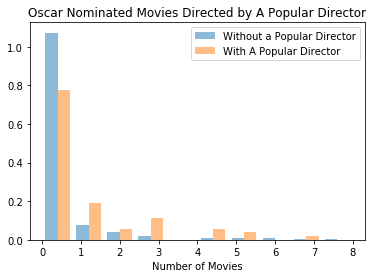

In [27]:
plt.hist([no_pop_director_won_oscar, has_pop_director_won_oscar], 10, alpha=0.5, density=True)
plt.xlabel('Number of Movies')
plt.title('Oscar Nominated Movies Directed by A Popular Director')
plt.legend(['Without a Popular Director','With A Popular Director'])

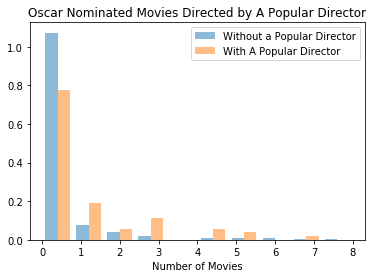

In [28]:
plt.hist([no_pop_director_won_oscar, has_pop_director_won_oscar], 10, alpha=0.5, density=True)
plt.xlabel('Number of Movies')
plt.title('Oscar Nominated Movies Directed by A Popular Director')
plt.legend(['Without a Popular Director','With A Popular Director'])